### Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.patches import Polygon

### Calibration

In [2]:
def calibrate(calibration_images_name, nx, ny):
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    fnames = glob.glob(calibration_images_name)

    for fname in fnames:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    if(len(objpoints) > 0):
        print("Success: Camera calibrated")
    else:
        print("Error: Unable to calibrate camera")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
ret, mtx, dist, rvecs, tvecs = calibrate("camera_cal/calibration*.jpg", 9, 6)

Success: Camera calibrated


### Undistort

In [4]:
def undistort_image(img, ret, mtx, dist, rvecs, tvecs):
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_img

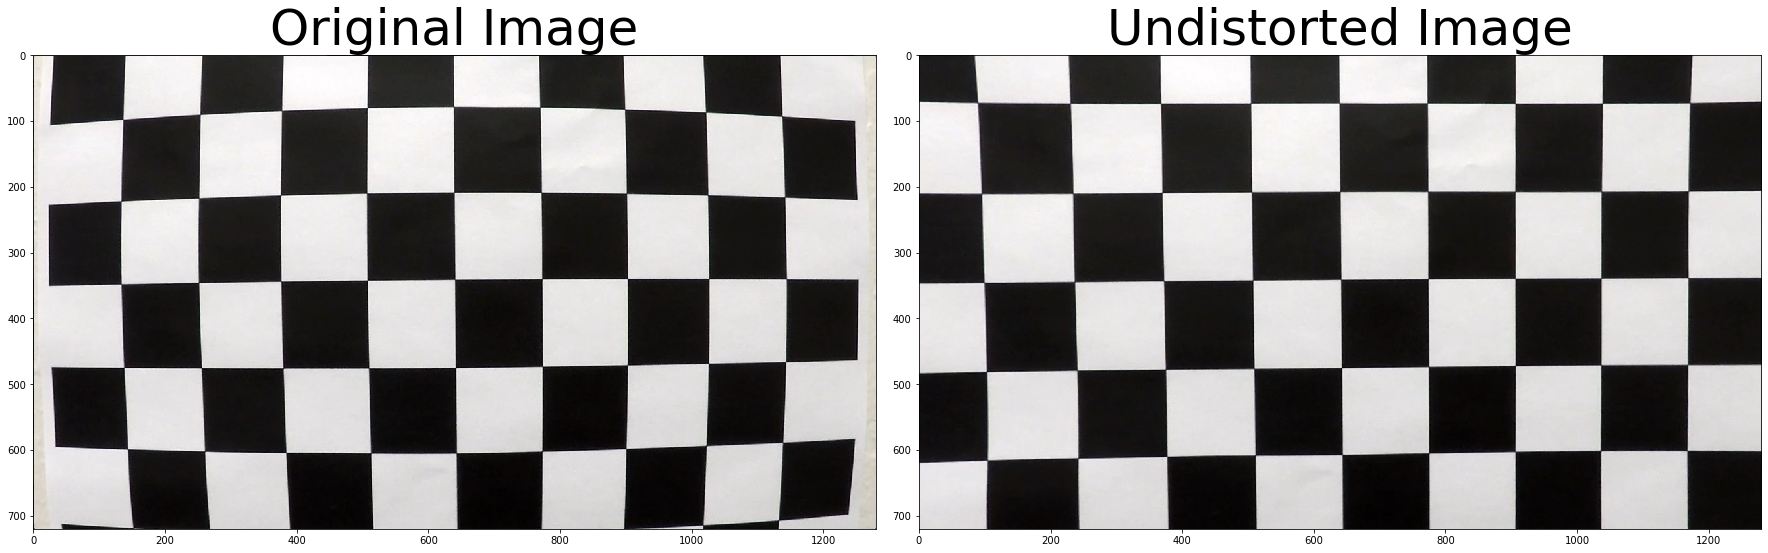

In [5]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted_img = undistort_image(img, ret, mtx, dist, rvecs, tvecs)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Original 

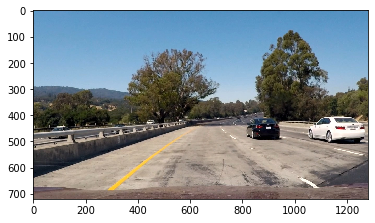

In [6]:
img = mpimg.imread('test_images/test1.jpg')
plt.imshow(img)

### Undistort Image

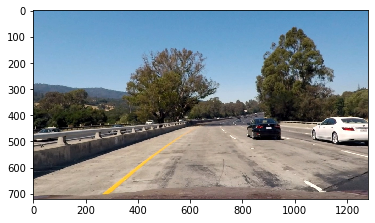

In [7]:
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_img)

### Sobel Filter

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernal=3, sobel_thresh = (0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernal))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernal))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Return the result
    return binary_output

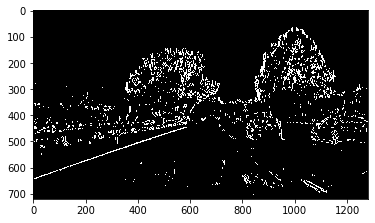

In [9]:
sobelx_output = abs_sobel_thresh(undistorted_img,'x', 15, (30,100))
plt.imshow(sobelx_output, cmap = 'gray')

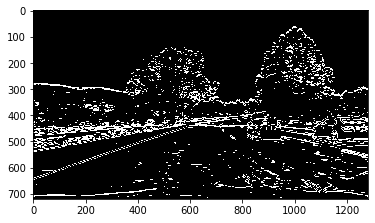

In [10]:
sobely_output = abs_sobel_thresh(undistorted_img,'y', 15, (30,100))
plt.imshow(sobely_output, cmap = 'gray')

### Magnitude Threshold Filter 

In [11]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

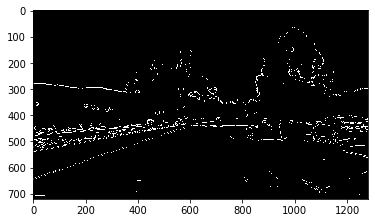

In [12]:
mag_output = mag_thresh(undistorted_img, 15, (70,100))
plt.imshow(mag_output, cmap = 'gray')

### Gradient Filter

In [13]:
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

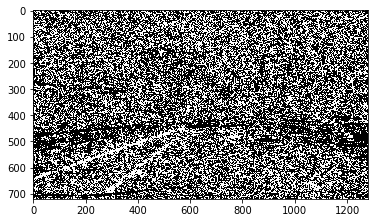

In [14]:
grad_output = dir_threshold(undistorted_img, 15, (0.7,1.3))
plt.imshow(grad_output, cmap = 'gray')

### Color Filter on S channel

In [15]:
def color_filter(img, s_thresh):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Perform on S channel and L Channel
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

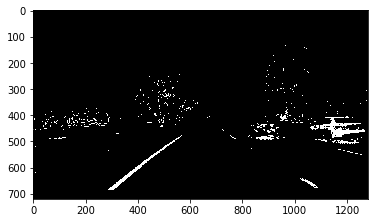

In [16]:
s_channel_thresh = (170, 255)
s_channel_img = color_filter(img, s_channel_thresh)
plt.imshow(s_channel_img, cmap = 'gray')

### Gradient Direction Filter

In [17]:
def find_gradient_edges(img, ksize, s_thresh_x, s_thresh_y, m_thresh, d_thresh):
    
    # Copy for modifications
    img = np.copy(img)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernal = ksize, sobel_thresh = s_thresh_x)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernal = ksize, sobel_thresh = s_thresh_y)
    mag_binary = mag_thresh(img, sobel_kernel = ksize, mag_thresh = m_thresh)
    dir_binary = dir_threshold(img, sobel_kernel = ksize, dir_thresh = d_thresh)

    # Combination Filter
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

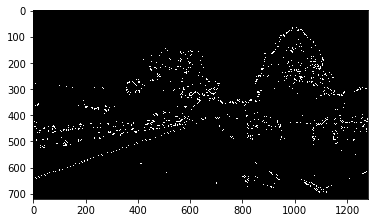

In [18]:
# Thresholds
ksize = 15
s_thresh_x = (30, 100)
s_thresh_y = (30, 100)
m_thresh = (70, 100)
d_thresh = (0.7, 1.3)
gradient_img = find_gradient_edges(undistorted_img, ksize, s_thresh_x, s_thresh_y, m_thresh, d_thresh)
plt.imshow(gradient_img, cmap = 'gray')

### Gradient Direction / Color Filter Combination 

In [19]:
def combine_binaries(gradient_img, s_channel_img):
    combined_binary_img = np.zeros_like(gradient_img)
    combined_binary_img[(s_channel_img == 1) | (gradient_img == 1)] = 1
    return combined_binary_img

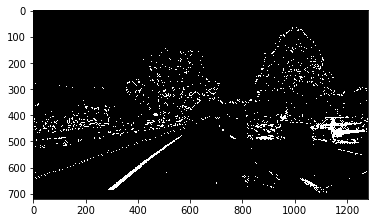

In [20]:
combined_binary_img = combine_binaries(gradient_img, s_channel_img)
plt.imshow(combined_binary_img, cmap = 'gray')

### Perspective Transform

In [21]:
def warp(img, src_coord, dst_coord):
    
    img_size = (img.shape[1], img.shape[0])
        
    # Perspective Transform Matrix
    M = cv2.getPerspectiveTransform(src_coord, dst_coord)

    # Inverse Perspective Transform Matrix
    Minv = cv2.getPerspectiveTransform(dst_coord, src_coord)
    
    # Apply Matrix on Image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

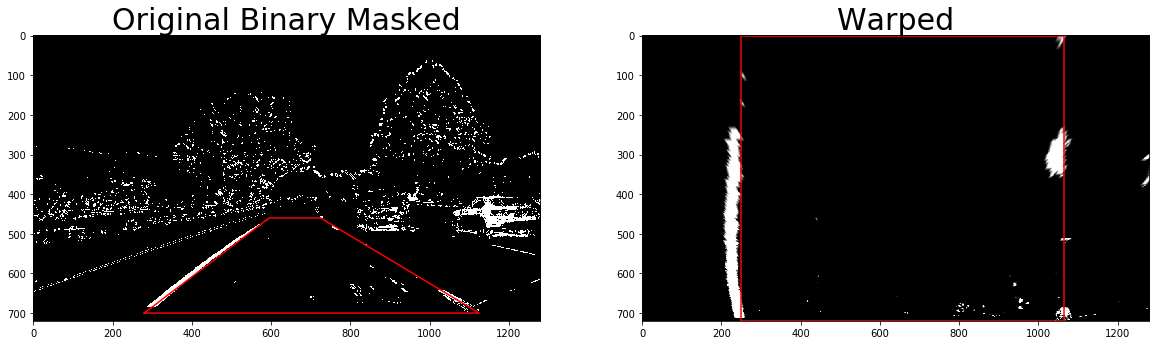

In [22]:
src_coord = np.float32(
            [[280,  700],  # Bottom Left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right
dst_coord = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

binary_warped, M, Minv = warp(combined_binary_img, src_coord, dst_coord)

# Plot images with perspective coordinates
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Binary Masked', fontsize = 30)
ax1.plot(Polygon(src_coord).get_xy()[:, 0], Polygon(src_coord).get_xy()[:, 1], color='red')
ax1.imshow(combined_binary_img, cmap = 'gray')

ax2.set_title('Warped', fontsize = 30)
ax2.plot(Polygon(dst_coord).get_xy()[:, 0], Polygon(dst_coord).get_xy()[:, 1], color='red')
ax2.imshow(binary_warped, cmap = 'gray')

### Histogram of Lane Lines - Finding Peaks of Lane Pixels

In [23]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

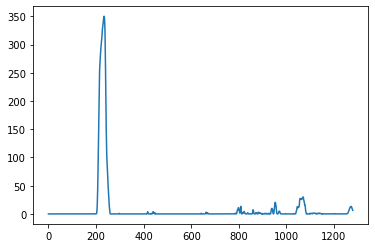

In [24]:
# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)

### Create Sliding Windows 

In [25]:
def create_sliding_windows(binary_warped, b_plot = False):
    
    # PARAMETERS
    nwindows = 9 # number of windows
    margin = 100 # width of windows
    minpix = 50  # min pixels to recenter window
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    if b_plot:
         out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if b_plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
   
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if b_plot:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        return out_img, (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)
    else:
        return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)

### Search Around Polynomial 

Search around previous polynomials for next lane lines to make the algorithm more efficient 

In [26]:
def detect_lane_lines(binary_warped, line_fit, b_plot):
    if line_fit is None:
        return create_sliding_windows(binary_warped, b_plot)
        
    # Parameters
    margin = 100
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Unpack Values
    left_fit = line_fit[0]
    right_fit = line_fit[1]
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # If nothing is found use the longer approach to find lines
    if leftx.size == 0 or rightx.size == 0:
        return create_sliding_windows(binary_warped, b_plot)
    
    # Else use the margins to reduce time-complexity
    else:
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        if b_plot:
            ## Visualization ##
            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
            # Plot the polynomial lines onto the image
            plt.plot(left_fitx, ploty, color='red')
            plt.plot(right_fitx, ploty, color='red')
            ## End visualization steps ##
            return result, (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)
        else:
            return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty)
    

### Finding Lane Lines with Sliding Windows (No Previous Polynomials Found) (Long Approach if Necessary)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


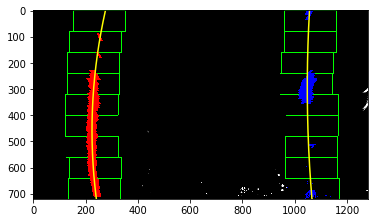

In [27]:
line_fit = ([0,0,0], [0,0,0]) # empty - such as first run
result_img, line_fit, left_pts, right_pts = detect_lane_lines(binary_warped, line_fit, b_plot = True)
plt.imshow(result_img)

### Finding Lane Lines without Sliding Windows (Previous Polynomials) (Short Approach)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


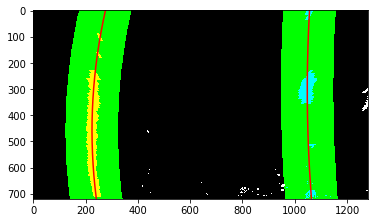

In [28]:
result_img, line_fit, left_pts, right_pts = detect_lane_lines(binary_warped, line_fit, b_plot = True)
plt.imshow(result_img)

### Draw Lane Region

In [33]:
def draw_lane(img, warped_img, left_pts, right_pts, Minv):
    
    # Create a new image for drawing
    zero = np.zeros_like(warped_img).astype(np.uint8)
    warp = np.dstack((zero, zero, zero))
    ploty = left_pts[1]

    pts_left = np.array([np.transpose(np.vstack([left_pts[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_pts[0], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw lane 
    cv2.fillPoly(warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    inverse_warp = cv2.warpPerspective(warp, Minv, (img.shape[1], img.shape[0])) 
    
    return cv2.addWeighted(img, 1, inverse_warp, 0.3, 0)

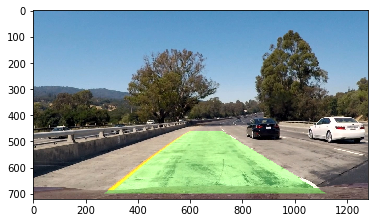

In [39]:
img_lane_drawn = draw_lane(img, binary_warped, left_pts, right_pts, Minv)
plt.imshow(img_lane_drawn)

### Measuring Cuvature of Lines

In [29]:
def measure_curvature(leftx, rightx, img_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curve = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Average the two
    av_curve = (left_curve + right_curve) / 2
    return av_curve

In [30]:
curverad = measure_curvature(left_pts[0], right_pts[0], img.shape)
print("Curve:", curverad, 'm')

Curve: 1222.9064253390757 m


### Car Offset

In [31]:
def find_car_offset(leftx, rightx, img_shape): 
    
    # Calculate Positions
    xm_per_pix = 3.7 / 700
    middle_img_pos = img_shape[1]//2
    car_pos = (leftx[-1] + rightx[-1]) / 2
    
    # Calculate Offset
    offset = (middle_img_pos - car_pos) * xm_per_pix

    return offset

In [32]:
offset = find_car_offset(left_pts[0], right_pts[0], img.shape)
print("Car Offset:", offset, "m")

Car Offset: -0.06641259409790504 m


### Add Text 

In [37]:
 def addText(img, curvature, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of curvature : {:.2f} m'.format(curvature),
                (20, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(img, 'Vehicle position : {:.2f} m of center'.format(offset),
                (670, 50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

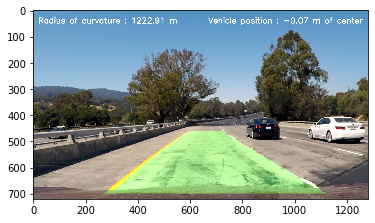

In [40]:
addText(img_lane_drawn, curverad, offset)
plt.imshow(img_lane_drawn)

### Pipeline

In [41]:
class ImagePipeline:
    def __init__(self, calibration_images_path):
    
        # Calibrate camera
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = calibrate(calibration_images_path, 9, 6)
        self.line_fit = None
    
    def __call__(self, img):
        
        # Choose a Sobel kernel size
        ksize = 15

        # Thresholds
        s_thresh_x = (30, 100)
        s_thresh_y = (30, 100)
        m_thresh = (70, 100)
        d_thresh = (0.7, 1.3)
        s_channel_thresh = (170, 255)
    
        src_coord = np.float32(
                [[280,  700],  # Bottom Left
                [595,  460],  # Top lefcombinedt
                [725,  460],  # Top right
                [1125, 700]]) # Bottom right
        dst_coord = np.float32(
                [[250,  720],  # Bottom left
                [250,    0],  # Top left
                [1065,   0],  # Top right
                [1065, 720]]) # Bottom right
    
    
        # Undistort Image
        undistorted_img = undistort_image(img, ret, mtx, dist, rvecs, tvecs)
        
        # Find lane edges
        combined_img = find_gradient_edges(undistorted_img, ksize, s_thresh_x, s_thresh_y, m_thresh, d_thresh)

        # Find S channel binary tuned to lane lines
        s_channel_img = color_filter(undistorted_img, s_channel_thresh)

        # Combine the two binary thresholds
        combined_binary_img = combine_binaries(combined_img, s_channel_img)
    
        # Warp Image
        binary_warped, M, Minv = warp(combined_binary_img, src_coord, dst_coord)
    
        # Get Lane Lines / points
        self.line_fit, left_pts, right_pts = detect_lane_lines(binary_warped, self.line_fit, b_plot = False)
    
        # Measure Curvatue of Lines
        curverad = measure_curvature(left_pts[0], right_pts[0], img.shape)
    
        # Measure Offset of Car With Respect to Middle of Lane
        offset = find_car_offset(left_pts[0], right_pts[0], img.shape)
    
        # Draw Lane Lines on image
        img_lane_drawn = draw_lane(img, binary_warped, left_pts, right_pts, Minv)
        
        # Label image with measurements
        addText(img_lane_drawn, curverad, offset)
    
        return img_lane_drawn

### Video Result

In [42]:
output = './output_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('./project_video.mp4')
process_image = ImagePipeline('./camera_cal/calibration*.jpg')
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Success: Camera calibrated


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_video.mp4.
Moviepy - Writing video ./output_video.mp4



Moviepy - Done !
Moviepy - video ready ./output_video.mp4
CPU times: user 20min 50s, sys: 24.9 s, total: 21min 15s
Wall time: 10min 28s


In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))